# Bias system analysis: $\texttt{COMBO_ACC}$

In this notebook I try to use the nested sampling to recover the posterior distribution of the parameters of the binary system with a purposedly wrong template for an accretion disk-only scenario. The evidence will be used in the Bayes factor calculation. 

### Import functions and stuff from pydd

In [1]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d

from pydd.analysis import get_match_pads
from pydd.binary import get_m_1, get_f_isco, get_m_2

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner
from scipy.interpolate import griddata
from scipy.stats import scoreatpercentile

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/pydd/binary.py:521: RuntimeWarning: invalid value encountered in log10
  vals_neg = np.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))


In [2]:
import environments_handy_functions

# Reload libraries (in case you change something)
import importlib
importlib.reload(environments_handy_functions)

from environments_handy_functions import (
    df_dt,  
    find_grid, 
    time_to_coal_cumul, 
    time_to_coal,
    phase_f_cumul, 
    f_1yr, 
    h_0, 
    mycalculate_SNR, 
    amplitude, 
    Psi,
    myVacuumBinary, myAccretionDisk, myDarkMatter, myCombination)

In [3]:
G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s

In [4]:
m1 = 1e5 * MSUN # kg
m2 = 10 * MSUN # kg
q = m2/m1

rho6 = 1.17e17 * MSUN / PC**3
r6 =  PC / 1e6
gammas = 7/3
epsv = 0.58

r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5e10 / Mach**2
alpha = -1/2

m_chirp = (m1 * m2)**(3/5) / (m1 + m2)**(1/5)

In [5]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "14"

### Select noise pattern

In [6]:
# Set detector
detector = "LISA"

In [7]:
# Set PSDs, choose observation time and SNR threshold (will set distance in signal system below)
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR 
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 1 * YR #seconds 
    SNR_THRESH = 100.0
    TITLE = "LISA"

### My version of $\texttt{get_signal_system}$

In [8]:
def myget_signal_system() -> Tuple[myVacuumBinary, myCombination, Tuple[float, float]]:
    
    m1 = 1e5 * MSUN # kg
    m2 = 10 * MSUN # kg
    
    rho6 = 1.17e17 * MSUN / PC**3
    r6 =  PC / 1e6
    gammas = 7/3
    epsv = 0.58
    
    r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
    r0 = 3 * r_s
    Mach = 100 
    sigma0 = 1.5e10 / Mach**2
    alpha = -1/2
    
    m_chirp = (m1 * m2)**(3/5) / (m1 + m2)**(1/5)
    
    _VB = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=100e6 * PC, 
    chirp_mass=m_chirp)
    
    q = _VB.q
    logL = np.log10(1 / q**(1/2))
    
    TT_C = 0.0 # time of coalescence
    F_C = _VB.frequency(6 * G * m1 / C**2)
    
    _COMBO = myCombination(m1=m1, 
                        m2=m2, 
                        dist=100e6 * PC, 
                        mach=Mach, 
                        sigma0=sigma0, 
                        alpha=alpha,
                        r0=r0,
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv, 
                        chirp_mass=m_chirp)

    # Frequency range and grids
    F_RANGE_D = find_grid(_COMBO, T_OBS)
    FS = np.linspace(max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 50_000)

    # Get dL such that SNR is as set above
    _fn = lambda dL: mycalculate_SNR(myCombination(m1=m1, 
                                                  m2=m2, 
                                                  dist=dL, 
                                                  mach=Mach, 
                                                  sigma0=sigma0, 
                                                  alpha=alpha,
                                                  r0=r0,
                                                  q=q, 
                                                  gammas=gammas, 
                                                  rho6=rho6, 
                                                  r6=r6, 
                                                  epsv=epsv, 
                                                  chirp_mass=m_chirp), FS[::-1], S_n)
    
    res = root_scalar(lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC))
    assert res.converged
    DL = res.root
    
    # Redefine DM and VB with "new" distance
    
    _COMBO_new = myCombination(m1=m1, 
                        m2=m2, 
                        dist=DL, 
                        mach=Mach, 
                        sigma0=sigma0,
                        alpha = alpha,
                        r0=r0,
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv, 
                        chirp_mass=m_chirp)
    
    _AD_new = myAccretionDisk(m1=m1, 
                        m2=m2, 
                        dist=DL, 
                        mach=Mach, 
                        sigma0=sigma0,
                        alpha = alpha,
                        r0=r0, 
                        chirp_mass=m_chirp)
    
    _VB_new = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=DL, 
    chirp_mass=m_chirp)

    return _VB_new, _COMBO_new, _AD_new, F_RANGE_D

In [9]:
_VB, _COMBO, _AD, F_RANGE_D = myget_signal_system()

FS = np.linspace(F_RANGE_D[-1], F_RANGE_D[0], 10000)

In [10]:
PAD_LOW, PAD_HIGH = get_match_pads(FS[::-1])  # padding for likelihood calculation

## Add waveform and noise patterns

For the moment, I am not going to use the $\texttt{get_frequency_noise}$ function, only defining it for further use. 

In [11]:
def get_frequency_noise(psd, fs):
    
    delta_f = fs[0] - fs[1]
    sigma = np.sqrt(psd(fs)/(4 * delta_f))
    not_zero = (sigma != 0)
    sigma_red = sigma[not_zero]
    noise_re = np.random.normal(0, sigma_red)
    noise_co = np.random.normal(0, sigma_red)

    noise_red = (1/np.sqrt(2)) * (noise_re + 1j * noise_co)

    noise = np.zeros(len(sigma), dtype=complex)
    noise[not_zero] = noise_red

    return noise

In [12]:
def waveform(params_h, fs, S_n):
    flen = len(fs)
    delta_f = fs[0] - fs[1]
    
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0))
    noise = get_frequency_noise(S_n, fs)
    
    wf_h_noise = wf_h + noise
    
    return wf_h, noise, wf_h_noise

In [13]:
# Define the signal: 

signal = waveform(_COMBO, FS, S_n)[0] # 0: noiseless, 1: noise-only, 2: noisy

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


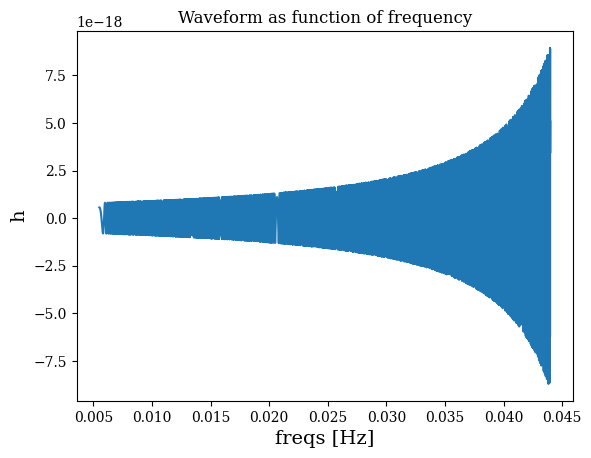

In [14]:
# see the waveform

plt.plot(FS[::-1], signal)
plt.xlabel('freqs [Hz]')
plt.ylabel('h')
plt.title('Waveform as function of frequency');

# Functions for likelihood calculation

In [15]:
def calculate_match_unnormd_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[0] - fs[1] # I have set out a reversed grid wr to the pydd version
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0))# h is the model/template
    wf_d = signal # d is the signal including noise
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    return np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()


def loglikelihood_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Log-likelihood for a signal from a binary params_d modeled using params_h,
    maximized over the distance to the binary, Phi_c and t_c (i.e., all
    extrinsic parameters).
    """
    # Waveform magnitude
    ip_hh = mycalculate_SNR(params_h, fs, S_n) ** 2
    # Inner product of waveforms, maximized over Phi_c by taking absolute value
    ip_hd = calculate_match_unnormd_fft(params_h, params_d, fs, pad_low, pad_high, S_n)
    # Maximize over distance
    return 1 / 2 * ip_hd ** 2 / ip_hh

### Check 'max' likelihood 

In [16]:
maxll = loglikelihood_fft(_COMBO, _COMBO, FS, PAD_LOW, PAD_HIGH)
print(maxll) # check with different fs

5004.8904032721775


In [17]:
# symmetric priors around true value

true_value = np.array([_COMBO.Binary_init.chirp_mass, _COMBO.DarkMatter_init.rho6, _COMBO.DarkMatter_init.gammas, _COMBO.Binary_init.q, _COMBO.Accretion_init.alpha, _COMBO.Accretion_init.sigma0])

print('true value list: ', true_value)

true value list:  [ 7.91640182e+32  7.91900727e-03  2.33333333e+00  1.00000000e-04
 -5.00000000e-01  1.50000000e+06]


In [18]:
mtrue = 0

In [19]:
def ptform(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values. () brackets have flat prior choices.
    """
    assert u.shape == (4,)
    
    m_chirp = np.array([(- 1 + 2 * (1) * u[0])])
    q = np.array([-4.1 + 2 * (1.5) * u[3]])
    alpha = np.array([-1.15 + (0.55) * u[1]])
    sigma0 = np.array([6.3 + 3.4 * u[2]]) # np.array([np.log10(true_value[5]) - 0.1 + 2 * (1.8) * u[2]])
    
    return np.array([m_chirp, alpha, sigma0, q]).reshape(4,) 


def unpack(x: np.ndarray) -> myAccretionDisk:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    dMc = x[0]
    dalpha = x[1]
    dsigma0 = x[2]
    dq = x[3]
    
    Mc = _COMBO.Binary_init.chirp_mass + dMc * MSUN
    q = 10**(dq)
    alpha = _COMBO.Accretion_init.alpha + dalpha
    sigma0 = 10**(dsigma0)
    
    m_1 = get_m_1(Mc, q)
    m_2 = get_m_2(Mc, q)
    
    DL = _COMBO.Binary_init.dist
    
    r_s = 2 * G * m_1/ C**2 # Schwartzschild radius of m1
    r0 = 3 * r_s
    Mach = 100
    
    return myAccretionDisk(mach=Mach, m1=m_1, m2=m_2, r0=r0, dist=DL, sigma0=sigma0, alpha=alpha, chirp_mass=Mc)


def get_ll_fft(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack(x)
    return loglikelihood_fft(ad_h, _COMBO, FS, PAD_LOW, PAD_HIGH, S_n)

In [20]:
xs = []
lls = []
for _ in trange(1000):
    xs.append(ptform(np.random.rand(4)))
    lls.append(get_ll_fft(xs[-1]))
              
xs = np.array(xs)
lls = np.array(lls)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
mtrue = 0
alpha_true = 0
logq_true = np.log10(_COMBO.Binary_init.q)
logsigma0_true = np.log10(sigma0)

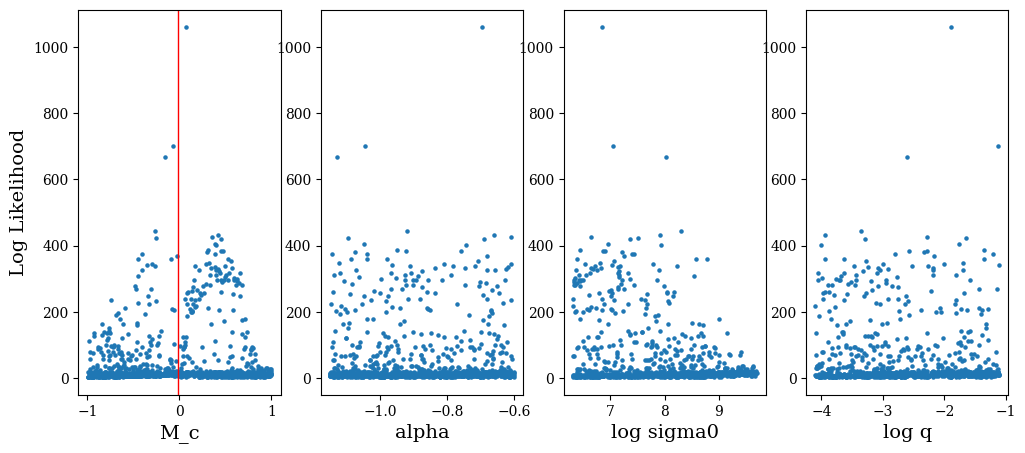

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(12, 5))

for i in range(0, 4): 

    ax[i].scatter(xs[:, i], lls, s=5)
    ax[i].set_title('')
    

ax[0].set_ylabel('Log Likelihood')

ax[0].set_xlabel('M_c')
ax[3].set_xlabel('log q')
ax[1].set_xlabel('alpha')
ax[2].set_xlabel('log sigma0')

ax[0].axvline(x=-0.015, c='red', linewidth=1);
#ax[1].axvline(x=alpha_best - alpha, c='red', linewidth=1)
#ax[2].axvline(x=np.log10(sigma0_best), c='red', linewidth=1)
#ax[3].axvline(x=np.log10(q_best), c='red', linewidth=1);

# Results

In [23]:
with open('sampling-results/sampling_results_accVScomboQ5.pkl', 'rb') as f:
    data_out = pickle.load(f)

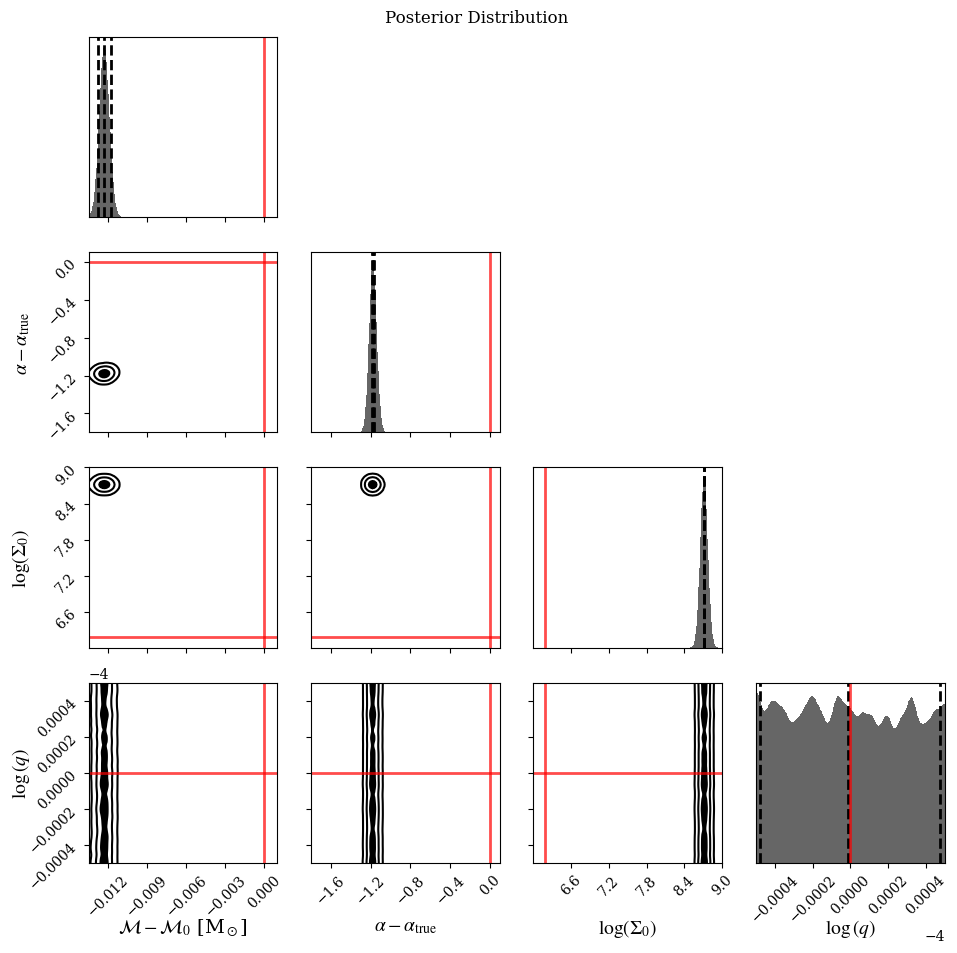

In [29]:
labels = [r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]", r"$\alpha - \alpha_{\mathrm{true}}$", r"$\log(\Sigma_0)$", "$\log{(q)}$"] # "$\log{(q)}$"

quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    data_out, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[mtrue, alpha_true, logsigma0_true, logq_true], 
    #verbose=True,
    span = [(-0.0135,0.001), (-1.8, 0.1), (6.0, 9), (np.log10(true_value[3]) - 0.0005, np.log10(true_value[3]) + 0.0005)]
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()
#plt.savefig('figures/COMBO_BIAS_accQ.png')
plt.show()

## Extract best results

In [30]:
samples = data_out.samples  # shape: (n_samples, n_parameters)
weights = np.exp(data_out.logwt - data_out.logz[-1]) 

m_c_best = (np.sum(samples[:, 0] * weights) / np.sum(weights)) * MSUN + m_chirp
alpha_best = (np.sum(samples[:, 1] * weights) / np.sum(weights)) + alpha
sigma0_best = 10**(np.sum(samples[:, 2] * weights) / np.sum(weights))
q_best = 10**(np.sum(samples[:, 3] * weights) / np.sum(weights))

m_1_best = get_m_1(m_c_best, q_best)
m_2_best = get_m_2(m_c_best, q_best)
r_s_best = 2 * G * m_1_best/ C**2 
r0_best = 3 * r_s_best

In [31]:
DL = _COMBO.Binary_init.dist

_ACC_best = myAccretionDisk(mach=Mach, 
                            m1=m_1_best, m2=m_2_best, 
                            r0=r0_best, dist=DL, 
                            sigma0=sigma0_best, alpha=alpha_best, 
                            chirp_mass=m_c_best)

_ACC_theoret = myAccretionDisk(mach=Mach, 
                            m1=m1, m2=m2, 
                            r0=r0, dist=DL, 
                            sigma0=sigma0, alpha=alpha, 
                            chirp_mass=m_chirp)

In [32]:
def calculate_match_NORMD_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[0] - fs[1] # I have set out a reversed grid wr to the pydd version
    
    # define the waveform and match
    
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0)) 
    wf_d = amplitude(fs, params_d) * np.exp(1j * Psi(fs, params_d, TTC=0.0, PHI_C=0.0)) 
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    # Maximize over time shift using IFFT trick
    unnormalized_match = np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()
    
    # NEW!
    
    # Now calculate the normalization terms with self-inner products
    inner_product_hh = 4 * wf_h.conj() * wf_h / Sns * df
    inner_product_hh_padded = np.concatenate((pad_low, inner_product_hh, pad_high))
    norm_h = np.abs(len(inner_product_hh_padded) * np.fft.ifft(inner_product_hh_padded)).max()

    inner_product_dd = 4 * wf_d.conj() * wf_d / Sns * df
    inner_product_dd_padded = np.concatenate((pad_low, inner_product_dd, pad_high))
    norm_d = np.abs(len(inner_product_dd_padded) * np.fft.ifft(inner_product_dd_padded)).max()

    # Normalize the match to be from 0 to 1
    normalized_match = unnormalized_match / np.sqrt(norm_h * norm_d)
    
    return normalized_match

In [33]:
def mismatch(params_h, params_d, fs, pad_low, pad_high, S_n=S_n):
    '''Returns waveforms (different in integration methods) mismatch as a number between 0 and 1. 0 means low mismatch, 1 means high mismatch.'''
    return 1 - calculate_match_NORMD_fft(params_h, params_d, fs, pad_low, pad_high, S_n=S_n)

In [34]:
# calculate mismatch using best sampled vals

print('best mis', mismatch(_COMBO, _ACC_best, FS, PAD_LOW, PAD_HIGH, S_n=S_n))
print('original mis', mismatch(_COMBO, _ACC_theoret, FS, PAD_LOW, PAD_HIGH, S_n=S_n))

best mis 0.0027639251006862375
original mis 0.9434458610759324


---

## Is the frequency grid FS enough? (a posteriori)

In [35]:
fs_array = [np.linspace(F_RANGE_D[-1], F_RANGE_D[0], i) for i in range(1000, 50000, 500)]

In [36]:
# padding for likelihood calculation

pad_low_array = [get_match_pads(fs_array[i][::-1])[0] for i in range(0, len(fs_array))]
pad_high_array = [get_match_pads(fs_array[i][::-1])[1] for i in range(0, len(fs_array))]

In [37]:
# find faithfulness

faith_i = [calculate_match_NORMD_fft(_COMBO, _ACC_best, fs_array[i], pad_low_array[i], pad_high_array[i], S_n) for i in range(0, len(fs_array))]

In [38]:
# find mismatch

mis_i = 1 - np.array(faith_i)

In [39]:
# find where the faithfulness saturates:

f_dim = np.array(range(1000, 50000, 500))
#max_mis_i = f_dim[mis_i > 0.94][0]

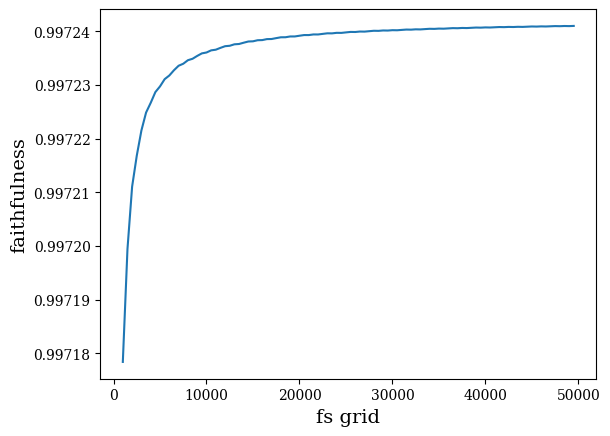

In [40]:
plt.plot(f_dim, faith_i)
plt.xlabel('fs grid')
plt.ylabel('faithfulness')
#plt.axvline(x=max_mis_i, c='red', linestyle='--', label=fr'len(FS) = {max_mis_i}')
#plt.legend()
plt.show()

In [41]:
# I checked that 6000 pts for FS grid are enough to reduce noise in mismatch analysis.

---

# 1D mismatch

One-dimensional mismatch varying a single parameter.

In [42]:
# define range of values: 

m_range = np.linspace(m_chirp/MSUN - 2, m_chirp/MSUN + 2, 1000) * MSUN
logsigma0_range = np.linspace(6, 9, 1000)
alpha_range = np.linspace(-2.5, -0.1, 1000)
logq_range = np.linspace(-5.5, -1.5, 1000)

m_1_range = get_m_1(m_range, q_best)
m_2_range = get_m_2(m_range, q_best)
r_s_range = 2 * G * m_1_range/ C**2 
r0_range = 3 * r_s_range

In [43]:
# define the environments

AD_range = [myAccretionDisk(mach=Mach, 
                            m1=m_1_range[i], m2=m_2_range[i], 
                            r0=r0_range[i], dist=DL, 
                            sigma0=sigma0_best, alpha=alpha_best, 
                            chirp_mass=m_range[i]) for i in range(0, len(m_range))]

In [44]:
# find mismatch

mis = [mismatch(AD_range[i], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(m_range))]

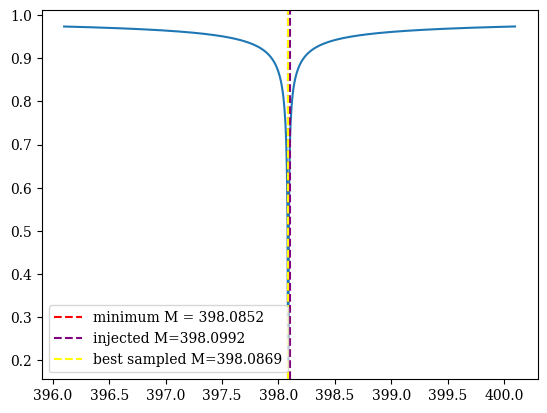

In [45]:
plt.plot(m_range/MSUN, mis)
plt.axvline(x=m_range[np.where(mis == np.min(mis))[0][0]]/MSUN, c='red', linestyle='--', label=f'minimum M = {m_range[np.where(mis == np.min(mis))[0][0]]/MSUN:.4f}')
plt.axvline(x=m_chirp/MSUN, c='purple', label=f'injected M={m_chirp/MSUN:.4f}', linestyle='--')
plt.axvline(x=m_c_best/MSUN, c='yellow', label=f'best sampled M={m_c_best/MSUN:.4f}', linestyle='--')
plt.legend(loc='lower left')
#plt.xlim(397.3, 398.7)
plt.show()

In [46]:
# q

m_1_range1 = get_m_1(m_c_best, 10**logq_range)
m_2_range1 = get_m_2(m_c_best, 10**logq_range)
r_s_range1 = 2 * G * m_1_range1/ C**2 
r0_range1 = 3 * r_s_range1


_acc_q_test = [myAccretionDisk(mach=Mach, 
                            m1=m_1_range1[i], m2=m_2_range1[i], 
                            r0=r0_range1[i], dist=DL, 
                            sigma0=sigma0_best, alpha=alpha_best, 
                            chirp_mass=m_c_best) for i in range(0, len(logq_range))]

In [47]:
# find mismatch

mis_q = [mismatch(_acc_q_test[i], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(logq_range))]

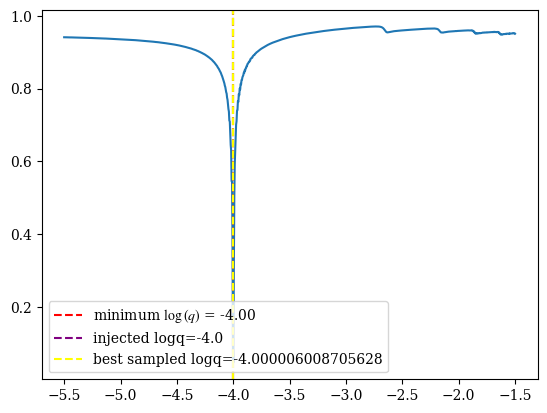

In [48]:
plt.plot(logq_range, mis_q)
plt.axvline(x=logq_range[np.where(mis_q == np.min(mis_q))[0][0]], c='red', linestyle='--', label=fr'minimum $\log{{(q)}}$ = {logq_range[np.where(mis_q == np.min(mis_q))[0][0]]:.2f}')
plt.axvline(x=np.log10(q), c='purple', label=f'injected logq={np.log10(q)}', linestyle='--')
plt.axvline(x=np.log10(q_best), c='yellow', label=f'best sampled logq={np.log10(q_best)}', linestyle='--')
plt.legend(loc='lower left')

plt.show()

In [49]:
# sigma0

m_1 = get_m_1(m_c_best, q_best)
m_2 = get_m_2(m_c_best, q_best)
r_s_ = 2 * G * m_1/ C**2 
r_0 = 3 * r_s_


_acc_sig0_test = [myAccretionDisk(mach=Mach, 
                            m1=m_1, m2=m_2, 
                            r0=r_0, dist=DL, 
                            sigma0=10**logsigma0_range[i], alpha=alpha_best, 
                            chirp_mass=m_c_best) for i in range(0, len(logsigma0_range))]

In [50]:
# find mismatch

mis_sig0 = [mismatch(_acc_sig0_test[i], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(m_range))]

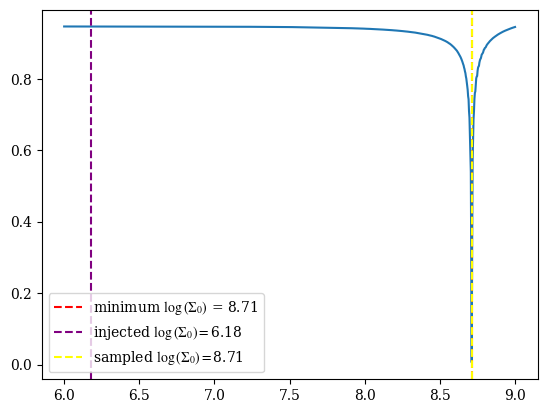

In [51]:
plt.plot(logsigma0_range, mis_sig0)
plt.axvline(x=logsigma0_range[np.where(mis_sig0 == np.min(mis_sig0))[0][0]], c='red', linestyle='--', label=fr'minimum $\log{{(\Sigma_0)}}$ = {logsigma0_range[np.where(mis_sig0 == np.min(mis_sig0))[0][0]]:.2f}')
plt.axvline(x=np.log10(sigma0), c='purple', label=fr'injected $\log{{(\Sigma_0)}} =${np.log10(sigma0):.2f}', linestyle='--')
plt.axvline(x=np.log10(sigma0_best), c='yellow', label=fr'sampled $\log{{(\Sigma_0)}} =${np.log10(sigma0_best):.2f}', linestyle='--')
plt.legend(loc='lower left')

plt.show()

In [52]:
# alpha

_acc_alpha_test = [myAccretionDisk(mach=Mach, 
                            m1=m_1, m2=m_2, 
                            r0=r_0, dist=DL, 
                            sigma0=sigma0_best, alpha=alpha_range[i], 
                            chirp_mass=m_c_best) for i in range(0, len(alpha_range))]

In [53]:
# calculate mismatch

mis_alpha = [mismatch(_acc_alpha_test[i], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(m_range))]

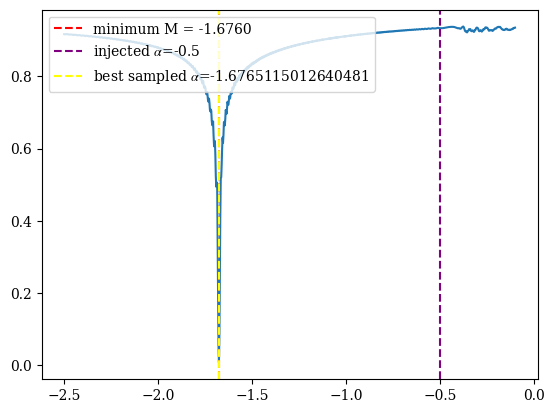

In [54]:
plt.plot(alpha_range, mis_alpha)
plt.axvline(x=alpha_range[np.where(mis_alpha == np.min(mis_alpha))[0][0]], c='red', linestyle='--', label=f'minimum M = {alpha_range[np.where(mis_alpha == np.min(mis_alpha))[0][0]]:.4f}')
plt.axvline(x=alpha, c='purple', label=fr'injected $\alpha$={alpha}', linestyle='--')
plt.axvline(x=alpha_best, c='yellow', label=fr'best sampled $\alpha$={alpha_best}', linestyle='--')
plt.legend(loc='upper left')

plt.show()

---

# 2D faithfulness

Two-dimensional $\textbf{faithfulness}$ (1-mismatch) varying two parameters at a time. 

In [55]:
# smaller grid range

m_range_NEW = np.linspace(m_chirp/MSUN - 2, m_chirp/MSUN + 2, 20) * MSUN
logsigma0_range_NEW = np.linspace(5, 10, 20)
alpha_range_NEW = np.linspace(-2.5, -0.1, 20)
logq_range_NEW = np.linspace(-5.5, -1.5, 20)

m_1_range_NEW = get_m_1(m_range_NEW, q_best)
m_2_range_NEW = get_m_2(m_range_NEW, q_best)
r_s_range_NEW = 2 * G * m_1_range_NEW/ C**2 
r0_range_NEW = 3 * r_s_range_NEW

m_1_range1_NEW = get_m_1(m_c_best, 10**logq_range_NEW)
m_2_range1_NEW = get_m_2(m_c_best, 10**logq_range_NEW)
r_s_range1_NEW = 2 * G * m_1_range1_NEW/ C**2 
r0_range1_NEW = 3 * r_s_range1_NEW

In [56]:
# sigma0, q

ad_s0q = [[myAccretionDisk(mach=Mach, 
                            m1=m_1_range1_NEW[j], m2=m_2_range1_NEW[j], 
                            r0=r0_range1_NEW[j], dist=DL, 
                            sigma0=10**(logsigma0_range_NEW[i]), alpha=alpha_best, 
                            chirp_mass=m_c_best) for i in range(0, len(logsigma0_range_NEW))] for j in range(0, len(logq_range_NEW))]

# sigma0, alpha

ad_s0a = [[myAccretionDisk(mach=Mach, 
                            m1=m_1_best, m2=m_2_best, 
                            r0=r0_best, dist=DL, 
                            sigma0=10**(logsigma0_range_NEW[i]), alpha=alpha_range_NEW[j], 
                            chirp_mass=m_c_best) for i in range(0, len(logsigma0_range_NEW))] for j in range(0, len(alpha_range_NEW))]

# sigma0, m_c

ad_s0m = [[myAccretionDisk(mach=Mach, 
                            m1=m_1_range_NEW[j], m2=m_2_range_NEW[j], 
                            r0=r0_range_NEW[j], dist=DL, 
                            sigma0=10**(logsigma0_range_NEW[i]), alpha=alpha_best, 
                            chirp_mass=m_range_NEW[j]) for i in range(0, len(logsigma0_range_NEW))] for j in range(0, len(m_range_NEW))]

# m_c, q --> too hard atm


# m_c, alpha

ad_am = [[myAccretionDisk(mach=Mach, 
                            m1=m_1_range_NEW[j], m2=m_2_range_NEW[j], 
                            r0=r0_range_NEW[j], dist=DL, 
                            sigma0=sigma0_best, alpha=alpha_range_NEW[i], 
                            chirp_mass=m_range_NEW[j]) for i in range(0, len(alpha_range_NEW))] for j in range(0, len(m_range_NEW))]

# alpha, q 

ad_aq = [[myAccretionDisk(mach=Mach, 
                            m1=m_1_range1_NEW[j], m2=m_2_range1_NEW[j], 
                            r0=r0_range1_NEW[j], dist=DL, 
                            sigma0=sigma0_best, alpha=alpha_range_NEW[i], 
                            chirp_mass=m_c_best) for i in range(0, len(alpha_range_NEW))] for j in range(0, len(logq_range_NEW))]

In [57]:
# calculate the mismatches

mis_s0q = [[mismatch(ad_s0q[i][j], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(logsigma0_range_NEW))] for j in range(0, len(logq_range_NEW))]
mis_s0a = [[mismatch(ad_s0a[i][j], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(logsigma0_range_NEW))] for j in range(0, len(alpha_range_NEW))]
mis_s0m = [[mismatch(ad_s0m[i][j], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(logsigma0_range_NEW))] for j in range(0, len(m_range_NEW))]
mis_am = [[mismatch(ad_am[i][j], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(alpha_range_NEW))] for j in range(0, len(m_range_NEW))]
mis_aq = [[mismatch(ad_aq[i][j], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(alpha_range_NEW))] for j in range(0, len(logq_range_NEW))]

# The $\mathcal{M}_c$ - $q$ case

In [58]:
m_1_matrix = np.array([[get_m_1(m_range_NEW[i], 10**(logq_range_NEW[j])) for i in range(0, len(m_range_NEW))] for j in range(0, len(logq_range_NEW))])
m_2_matrix = np.array([[get_m_2(m_range_NEW[i], 10**(logq_range_NEW[j])) for i in range(0, len(m_range_NEW))] for j in range(0, len(logq_range_NEW))])

r_s_matrix = 2 * G * m_1_matrix/ C**2 
r0_matrix = 3 * r_s_matrix

In [59]:
# check shape

r_s_matrix.shape

(20, 20)

Good!

In [60]:
# define accretion disk

ad_mq = [[myAccretionDisk(mach=Mach, 
                            m1=m_1_matrix[i][j], m2=m_2_matrix[i][j], 
                            r0=r0_matrix[i][j], dist=DL, 
                            sigma0=sigma0_best, alpha=alpha_best, 
                            chirp_mass=m_range_NEW[i]) for i in range(0, len(m_range_NEW))] for j in range(0, len(logq_range_NEW))]

In [61]:
# calculate mismatch

mis_mq = [[mismatch(ad_mq[i][j], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(m_range_NEW))] for j in range(0, len(logq_range_NEW))]

# Results

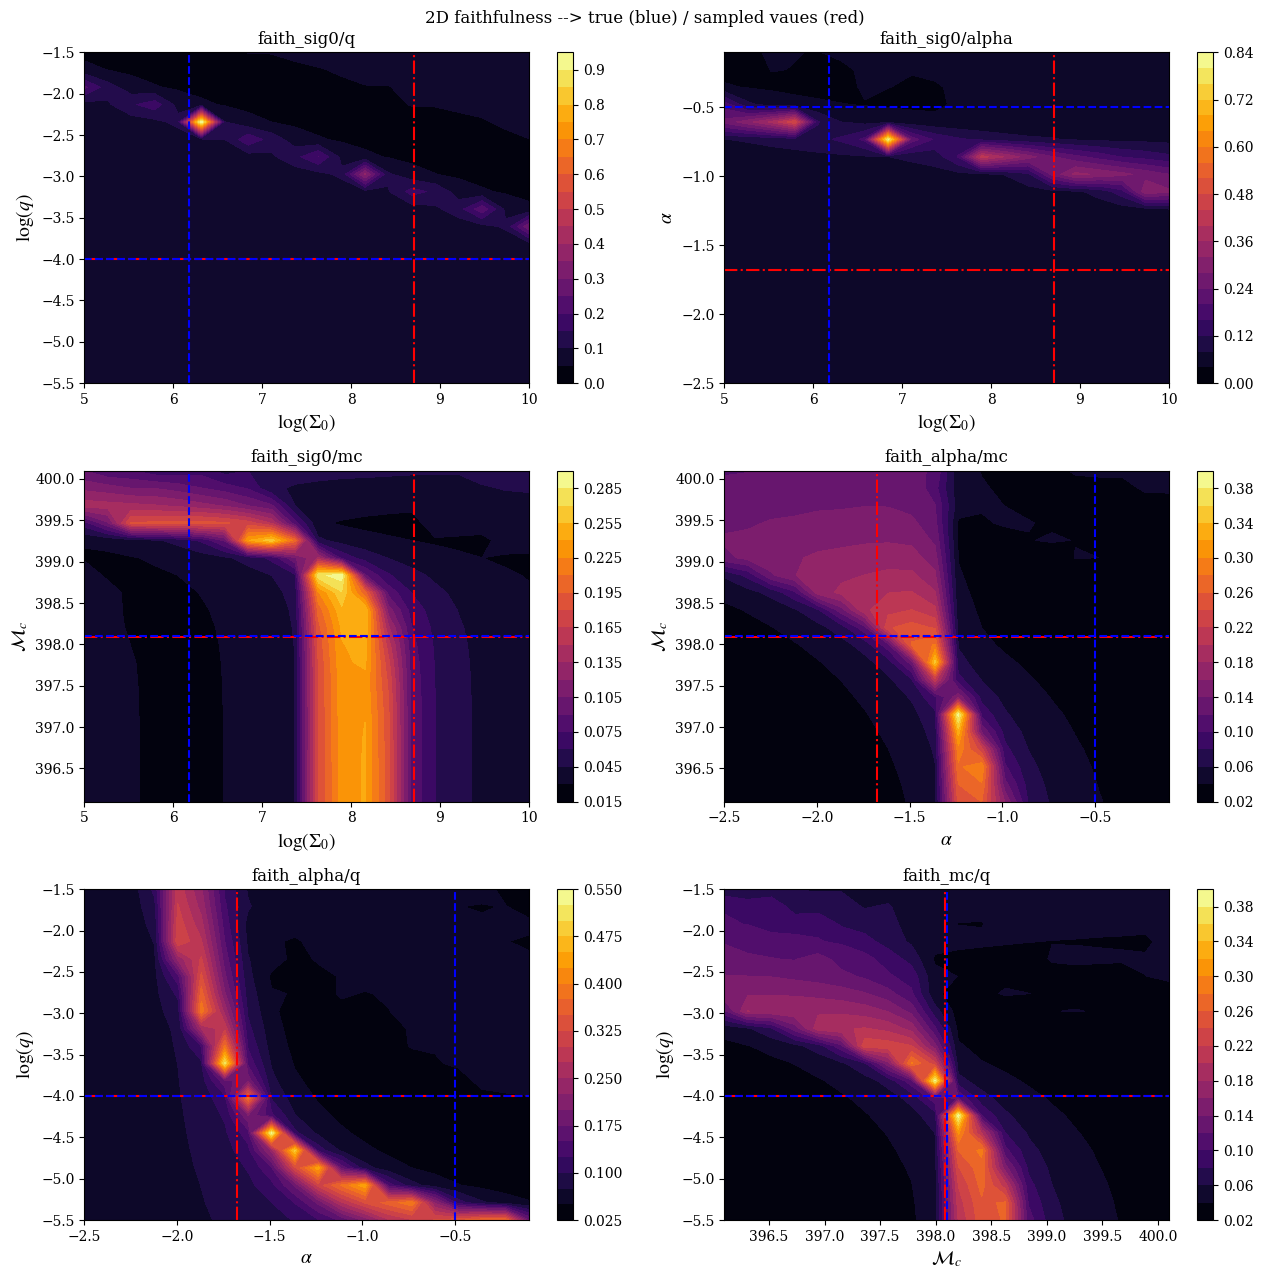

In [62]:
# Define grid ranges for each mismatch data
grids = {
    "faith_sig0/q": (logsigma0_range_NEW, logq_range_NEW, 1 - np.array(mis_s0q), r'$\log(\Sigma_0)$', '$\log(q)$', np.log10(sigma0_best), np.log10(q_best), np.log10(sigma0), np.log10(q)),
    "faith_sig0/alpha": (logsigma0_range_NEW, alpha_range_NEW, 1 - np.array(mis_s0a), r'$\log(\Sigma_0)$', r'$\alpha$', np.log10(sigma0_best), alpha_best, np.log10(sigma0), alpha),
    "faith_sig0/mc": (logsigma0_range_NEW, m_range_NEW/MSUN, 1 - np.array(mis_s0m), r'$\log(\Sigma_0)$', r'$\mathcal{M}_c$', np.log10(sigma0_best), m_c_best/MSUN, np.log10(sigma0), m_chirp/MSUN),
    "faith_alpha/mc": (alpha_range_NEW, m_range_NEW/MSUN, 1 - np.array(mis_am), r'$\alpha$', r'$\mathcal{M}_c$', alpha_best, m_c_best/MSUN, alpha, m_chirp/MSUN),
    "faith_alpha/q": (alpha_range_NEW, logq_range_NEW, 1 - np.array(mis_aq), r'$\alpha$', r'$\log(q)$', alpha_best, np.log10(q_best), alpha, np.log10(q)),
    "faith_mc/q": (m_range_NEW/MSUN, logq_range_NEW, 1 - np.array(mis_mq), r'$\mathcal{M}_c$', r'$\log(q)$', m_c_best/MSUN, np.log10(q_best), m_chirp/MSUN, np.log10(q))
}

# Create subplots: 2 rows, first row with 3 columns, second row with 2 columns
fig, axs = plt.subplots(3, 2, figsize=(13, 13))

# Flatten axes for easier iteration, leaving the last subplot empty
axs = axs.flatten()

# Plot contour plots for each dataset
for ax, (label, (x_range, y_range, data, x, y, xbest, ybest, xref, yref)) in zip(axs, grids.items()):
    X, Y = np.meshgrid(x_range, y_range)
    contour = ax.contourf(X, Y, data, levels=20, cmap='inferno')
    ax.axvline(x=xbest, c='red', linestyle='-.')
    ax.axhline(y=ybest, c='red', linestyle='-.', label='best values')
    ax.axvline(x=xref, c='blue', linestyle='--', label='reference values')
    ax.axhline(y=yref, c='blue', linestyle='--')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(label)
    fig.colorbar(contour, ax=ax)


plt.suptitle('2D faithfulness --> true (blue) / sampled vaues (red)')
plt.tight_layout()
plt.show()